In [9]:
%load_ext autoreload
%autoreload 2 

import numpy as np
import matplotlib.pyplot as plt
import enzyme_utils_hpw as utils
import pymc3 as pm
import theano.tensor as tt 
import scipy 
from scipy import stats 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
# warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

# enzymeBayes 

Final project for Alp Kucukelbir's Machine Learning Probabilistic Programming (COMS6998) by Jiayu Zhang and Kiran Gauthier. 

### Familiarizing ourselves with the data 

All data in this analysis has been graciously provided by Prof. Jennifer Ross, Mengqi Xu, and their collaborators from their paper [Direct Single Molecule Imaging of Enhanced Enzyme Diffusion](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.123.128101) and is available upon request.

Shown below are a representative trajectories from the buffer dataset (i.e. no urea).

In [11]:
dir_ = 'new_data/transformed_buffer/'
# dir_ = 'mengqi_buffer/'
x, y, t, track_info, lookup, track_id = utils.loadRawMinData(dir_, min_length=5, isDx=False)
x, y, t, dx, dy, dt, lookup, track_info = utils.removeAllOutliers(x, y, t, track_info)

15 files; 813 trajectories (length >= 5); Total 23909 data points


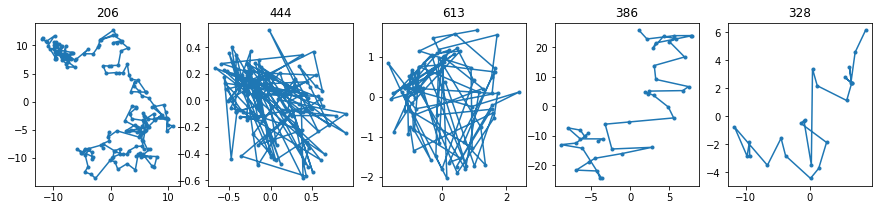

In [12]:
sel_ind = [206, 444, 613, 386, 328]
utils.manyplots_real(1, 5, sel_ind, track_info, [x, y, t])

## Box's Loop 

### Simple Brownian Diffusion model 

We begin our first iteration of Box's loop, shown below. 

<img src="boxsLoop.png" width="300" height="300"> 

#### Modeling 
In the modeling stage, we assume that the data can be analyzed by the simplest possible model, *Brownian diffusion* (BD). Derivation for this, and separate models, are given in helper notebook. 

#### Inference
Assuming an inverse gamma prior for the diffusion coefficient, one can derive the posterior analytically and the posterior results are plotted below for all 813 trajectories. 

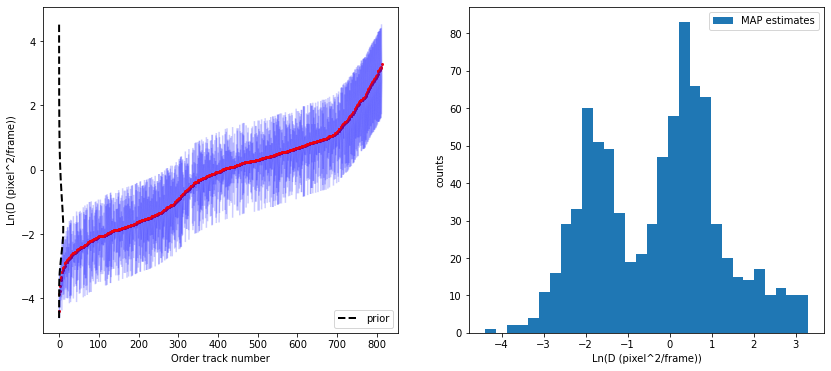

In [5]:
utils.draw_vertical_posterior_bm([dx, dy, dt], 0.25, 0.2, track_info)

#### Criticism  

From the analytic inference of the proposed model, there are two points we would like to address in the criticism stage, 
1. there are a series of very short trajectories ($len \sim 5$) which are very uncertain, marked by the wide posterior distributions in the left plot 
2. plotting the posterior mean of the diffusive trajectories in logspace, the distribution seems bimodal, implying that there is a slowly diffusive population and a more quickly diffusive population 

See above for the slow, confined trajectories which appear blob like, and the larger diffusive trajectories for which a more certain estimate of the diffusion coefficient can be derived. 

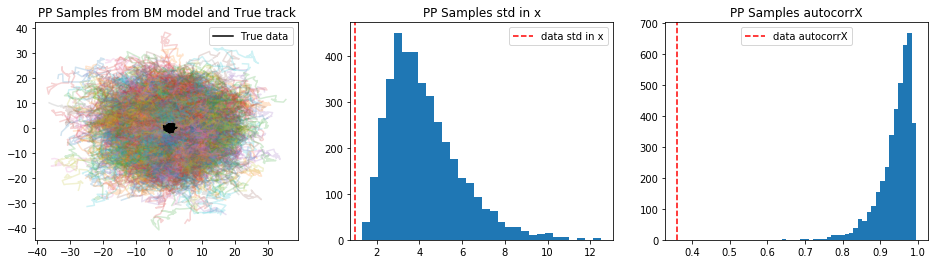

In [13]:
# track of interest
sx, sy, st = utils.loadSelectTraj(x, y, t, track_info, 613, False)
sx, sy, st = utils.removeOutLiar(sx, sy, st)
sdx, sdy, sdt = sx[1:]-sx[:-1], sy[1:]-sy[:-1], st[1:]-st[:-1]

utils.PPCs([sx, sy, st, sdx, sdy, sdt], 'bm') 

###### Posterior predictive checks (PPC) 

To criticise the model from a more quantitative standpoint, we will use PPC as a tool to generate statistics on two relevant metrics for the enzyme trajectories. Firstly, we consider the standard deviation of the motion of simulated enzymes in $1D$ and secondly, we consider the autocorrelation of the simulated enzymes along this same axis (see below for further discussion on autocorrelation in enzyme trajectories). 

In the case of the simple BD model, we see that it fails both of the PPC checks on this confined trajectory, indicating that it is very unlikely that this data was generated from this model. From this initial iteration of Box's loop, we propose two new model through which we can analyze the observed data. 
1. **Stuck Enzyme Model**: enzyme stuck on surface, all motion are noise due to camera.
2. **Brownian Motion in a Harmonic Potential**: BM subject to a harmoic potential well (polymer spring)

### Stuck Enzyme / Harmonic Potential Well models 

#### Modeling (Stuck) 

This model assumes that confined trajectories can be described by a single measurement noise parameter, $M_e$, which is common across all trajectories. See below for examples of a stuck enzyme with varying values of the measurement noise. 

#### Modeling (HPW) 

Although initially not considered for the BD model, we now also consider the measurement noise associated with tracking an individual enzyme. In this, we include three parameters for the harmonic potential well model, the diffusion coefficient, $D$, the potential well strength, $\lambda$, and the measurement noise, $M_e$. 


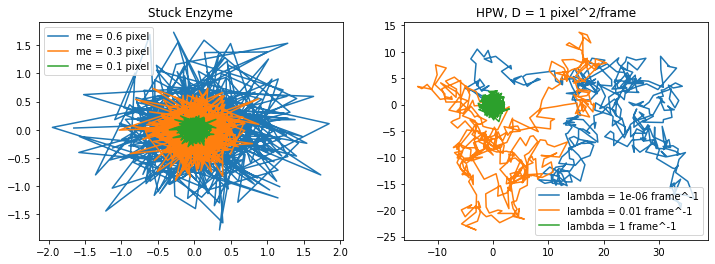

In [7]:
me = [0.6, 0.3, 0.1]
lambda_ = [1e-06, 0.01, 1]
n_times = 423 

utils.simulateData(me, lambda_, n_times)

#### Inference 

##### Inference on 1-parameter Stuck model ($M_e$) 

Inference for this model was very straightforward and the results of the inference are embedded in the **Criticism** stage of Box's loop below. 


##### Inference on 3-parameter HPW model ($D$, $\lambda$, $M_e$)  

We slightly rewrote the inferential HPW model to express the likelihood of a trajectory in the absence of a potential well, (i.e. tracks for which $\lambda \sim 0$) and identified 10 tracks which were diffusive (i.e. non-confined) to sample over $D$ and $M_e$ alone. Five of the ten are plotted below. 

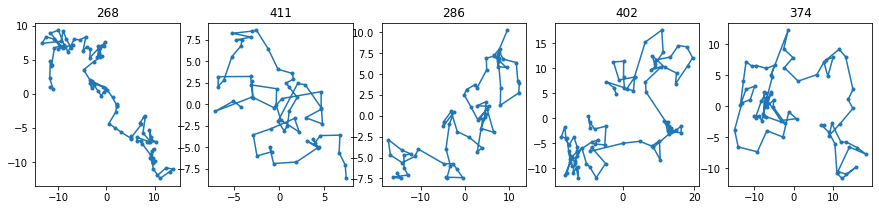

In [8]:
sel_ind = [268, 411, 286, 402, 374]
utils.manyplots_real(1, 5, sel_ind, track_info, [x, y, t])

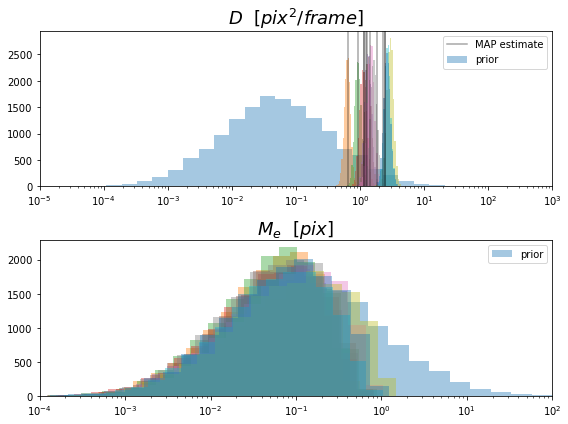

In [9]:
utils.plot_DMeAnalysis([dx, dy, dt, track_info])  

We note that there is only a small likelhood that the measurement noise is on the scale of a pixel, as judged by the posterior density, with much larger probability mass on the subpixel scale. Due to the fact that the vast majority of our trajectories diffuse further than a pixel per timestep, we eliminate $M_e$ from the analysis entirely. 

#### Criticism 

##### Autocorrelation analysis 

We quickly realized that in order to deconvolve the final two parameters in the HPW model, the diffusion coefficient, $D$, and the potential well strength, $\lambda$, we must importantly consider their relative values to the time between sequential data points in a trajectory. For the analysis of this dataset where the framerate is $\sim 12 fps$ or, $\sim 0.08$ seconds per frame, the HPW model finds it difficult to converge when $\lambda$ is large relative to $D$, this point is illustrated by the autocorrelation analysis on simulated data below: 

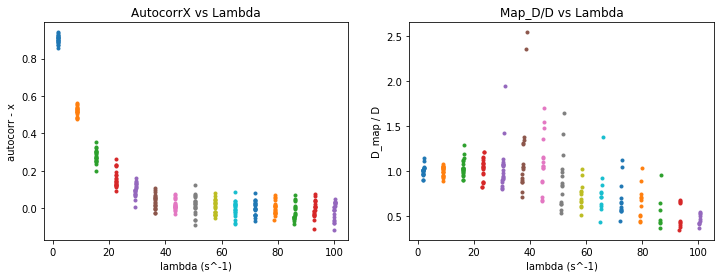

In [5]:
D = 0.175
t_ = np.linspace(0, 8*3, 101*3)
utils.plotAutoCorr(D, t_)

From a high level view, when $\lambda$ is small relative to a fixed $D$, the track is largely diffusive, for which each sequential point in the trajectory shares large correlation with the previous point. This fits well with *Model 1: Brownian Diffusion*. However, we see that with increasing values of $\lambda$, after say $\lambda \sim 20$, the autocorrelation is effectively zero, indicating that the well is so strong, each sequential position is simply sampled from a normal distribution, producing trajectories similar to the "stuck" case above which moreso fits *Model 2: Harmonic Potential Well*. 

Plotting the $MAP$ estimate of $D$ relative to the true $D$, we note there will be certain tracks in our dataset with highly confined behavior which our HPW model is not able to recover a confident estimation for D and $\lambda$

##### Posterior predictive checks 

Finally, we turn back to PPCs to examine the Stuck model from a quantitative standpoint, again examining the standard deviation and autocorrelation of simulated enzyme trajectories in $1D$. In this case, we fail the $1D$ autocorrelation PPC but pass the $1D$ standard deviation PPC. 

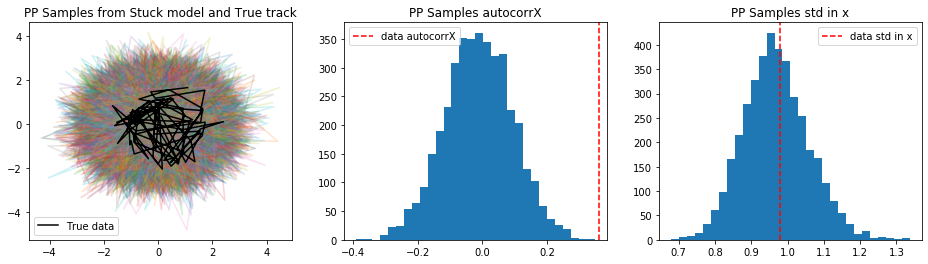

In [14]:
utils.PPCs([sx, sy, st, sdx, sdy, sdt], 'me') 

However, when considering the 2-parameter HPW model over $D$, $\lambda$, we pass both PPC checks, giving further creedence to this model being our best candidate for explaining the true enzyme trajectories. 

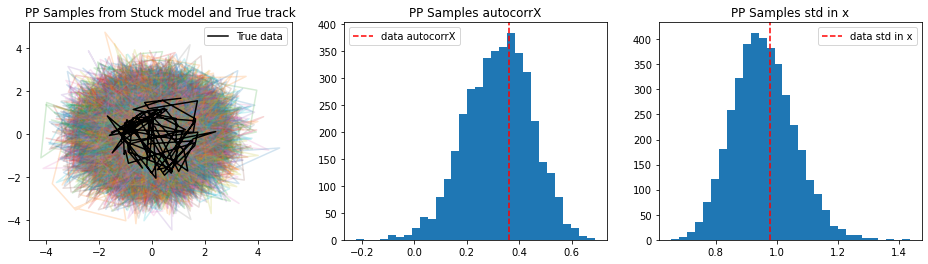

In [13]:
utils.PPCs([sx, sy, st, sdx, sdy, sdt], 'hpw') 

# Conclusions

##### Criticism 

Ultimately, we were interested in seeing if we would recover a similar estimate of the population level diffusion coefficient $D_{pop}$ as was arrived at in the paper. In this work, the population level diffusion coefficient was derived by a mean squared displacement (MSD) analysis for which trajectories were rejected if they fell under a Pearson $R^2$ coefficient of 0.9. We note that the total number of trajectories considered after this filter is $N = 141$. 

Incoporating the mean and standard deviation statistics for each individual trajectory in the buffer dataset (for which $N = 813$) relative to the estimate from the paper we see that we are able to arrive at a similar estimate in terms of the mean albeit with larger uncertainty. We look to extend the results of this analysis to prove or disprove whether enzymes do in fact diffuse faster in the presence of their substrate by performing this analysis for enzyme trajectories with non-zero urea concentrations. 

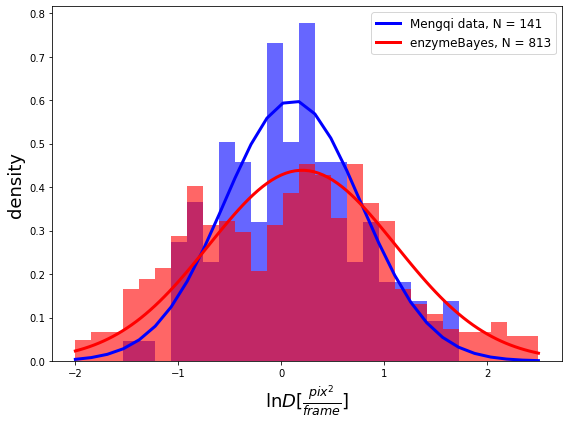

In [14]:
utils.plot_finalResults(track_info, min_length=None) 

LOOK AT ME 813 395


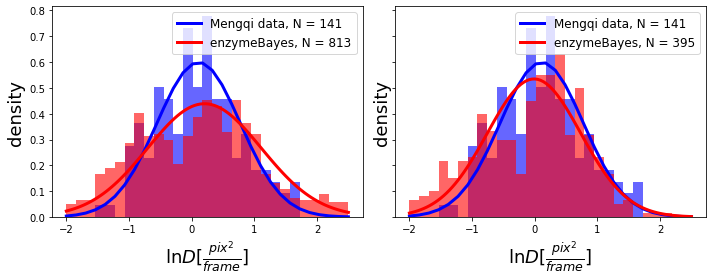

In [15]:
utils.plot_finalResults(track_info, min_length=10) 

Intuitively, we would like to think that with more data points included, we should have arrived at a tighter posterior mean. However, this is clearly not the case shown here.To explain why this is the case, we notice that there exits many short (~5), but fast diffusive tracks in the dataset (very likely that those tracks are artifacts of the tracking algorithm). If we remove that them by setting the minimun length of the tracks that we are going to analysis to 10, we see that the population distribution became tighter. This is one of the potentil areas that we can address in future modelling.